## Identifying Metastatic Tumors in Histopathological Slides of Lymphatic Node Sections using Convolutional Neural Networks

<img src="files/pcam.jpg" alt="metastases">

## Introduction <a class="anchor" id="introduction"></a>
Metastasis is the spread of cancer cells to new areas of the body, often by way of the lymphatic system or bloodstream. A metastatic cancer, or a metastatic tumor, is one that has spread from the primary site of origin, or where it started, into different areas of the body.

In order to identify metastatic tumors in histopathological slides, a biopsy is often done to remove tissue samples of affected sites of the body. A pathologist then has to examine the tissue samples under a microscope and decide whether or not a metastatic tumor is present in them. In the case of the presence of a metastatic tumor, the pathologist has to perform further investigations to find out how deadly the tumor is and which grade of metastasis it should be assigned. This has to be done manually and is a time consuming process. Furthermore, the decision depends on the expertise of the pathologist and the efficiency of the microscope in use.

Therefore, advanced techniques in deep learning such as convolutional neural networks could be of great help in automatically detecting, locating, and grading tumors in diseased tissues of the body. In order to exploit the full potential of these techniques, one could build a pipeline using massive amount of tissue histopathology data that have been evaluated by board-certified histopathologists, and train an ensemble of convolutional neural networks on the data.

## Project Understanding

###  What exactly is the problem?

The problem is a **binary image classification problem.** I am to identify the presence of metastatic tumors in the center 32x32 pixels of 96x96 pixels digital histopathology images. One key challenge is that metastatic tumors can be as small as single cells in a large area of tissue.

### What is known about the domain?

**The histopathological images are glass slide microscope images of lymph nodes that are stained with hematoxylin and eosin (H&E).** This staining method is one of the most widely used in medical diagnosis and it produces blue, violet and red colors. Dark blue hematoxylin binds to negatively charged substances such as nucleic acids and pink eosin to positively charged substances like amino-acid side chains (most proteins). Typically nuclei are stained blue, whereas cytoplasm and extracellular parts in various shades of pink.

Lymph nodes are small glands that filter the fluid in the lymphatic system and they are the first place a breast cancer is likely to spread. Histological assessment of lymph node metastases is part of determining the stage of breast cancer in TNM classification which is a globally recognized standard for classifying the extent of spread of cancer. The diagnostic procedure for pathologists is tedious and time-consuming as a large area of tissue has to be examined and small metastases can be easily missed.

## Data Understanding

The dataset consists of **220k training images and 57k evaluation images.** It is a subset of the [PCam dataset](https://github.com/basveeling/pcam) and the only difference between these two is that all duplicate images have been removed. The PCam dataset is derived from the [Camelyon16 Challenge dataset](https://camelyon16.grand-challenge.org/Data/) which contains 400 H&E stained whole slide images of sentinel lymph node sections that were acquired and digitized at 2 different centers using a 40x objective. The PCam's dataset including this one uses 10x undersampling to increase the field of view, which gives the resultant pixel resolution of 2.43 microns.

A positive label means that there is at least one pixel of tumor tissue in the center region (32 x 32px) of the image. Tumor tissue in the outer region of the patch does not influence the label. This means that a negatively labeled image could contain metastases in the outer region. Thus, it would be a good idea to crop the images to the center region.

## Table of contents
1. [Import the required libraries and packages](#import)
2. [Load the training and test datasets](#read_datasets)
3. [Check the target distribution](#target_distribution)
4. [View samples of the images](#view_samples)
5. [Data Augmentation](#Augmentation)
6. [Compute image statistics](#compute_stats)

## 1. Import the required libraries and packages <a class="anchor" id="import"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import pandas as pd
import seaborn as sns
from matplotlib import patches
from matplotlib import pyplot as plt

from tqdm import tqdm
from glob import glob
import albumentations as A
from albumentations import Compose, RandomRotate90, Transpose, Flip, OneOf, CLAHE, IAASharpen, IAAEmboss, RandomBrightnessContrast, JpegCompression, Blur, GaussNoise, HueSaturationValue, ShiftScaleRotate, Normalize

import cv2

import warnings
warnings.filterwarnings('ignore')

## 2. Load the datasets <a class="anchor" id="read_datasets"></a>

In [2]:
DATASET_PATH = "../input/histopathologic-cancer-detection/"
TRAIN_IMAGES_PATH = DATASET_PATH + 'train'
TEST_IMAGES_PATH = DATASET_PATH + 'test'

TRAIN_LABELS = pd.read_csv(DATASET_PATH + 'train_labels.csv')

In [3]:
TRAIN_LABELS.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [4]:
non_tumor_slides = TRAIN_LABELS[TRAIN_LABELS['label']==0]
tumor_slides = TRAIN_LABELS[TRAIN_LABELS['label']==1]

print('Number of slides with tumor(s) in the center 32x32 pixels region: {}'.format(tumor_slides.shape[0]))
print('Number of slides with no tumor(s) in the center 32x32 pixels region: {}'.format(non_tumor_slides.shape[0]))

print('Ratio of slides with no tumor(s) in the center 32x32 pixels region to slides with tumor(s)' \
      'in the center 32x32 pixels region: {:4f}'.format(len(non_tumor_slides)/len(tumor_slides))
     )

Number of slides with tumor(s) in the center 32x32 pixels region: 89117
Number of slides with no tumor(s) in the center 32x32 pixels region: 130908
Ratio of slides with no tumor(s) in the center 32x32 pixels region to slides with tumor(s)in the center 32x32 pixels region: 1.468945


## 3. Target Distribution <a class="anchor" id="target_distribution"></a>

{0: 'Slides with no tumor(s) in the center 32x32 pixels region', 1: 'Slides with tumor(s) in the center 32x32 pixels region'}


Text(0.5, 1.0, 'Distribution of the Labels in the Training Dataset')

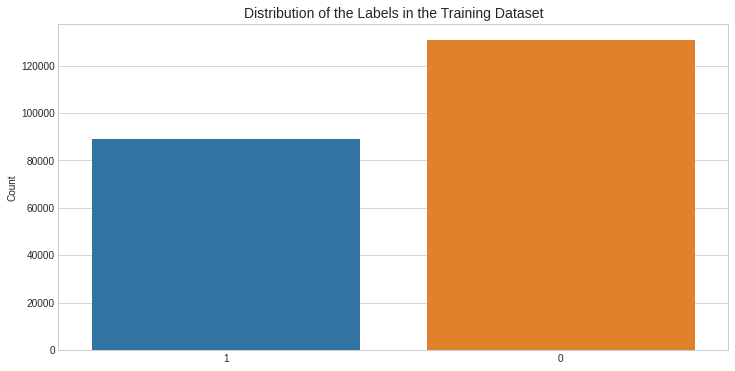

In [5]:
print({
    0: 'Slides with no tumor(s) in the center 32x32 pixels region', 
    1: 'Slides with tumor(s) in the center 32x32 pixels region'
})

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-whitegrid')
sns.countplot(TRAIN_LABELS['label'], order=[1, 0])
plt.xlabel('')
plt.ylabel('Count')
plt.title('Distribution of the Labels in the Training Dataset', size=14)

It is obvious that there are more slides with no tumor(s) in the center 32x32 pixels region than there are slides with tumor(s) in the 32x32 pixels region.

## 4. View samples of the images <a class="anchor" id="view_samples"></a>

In [6]:
def read_image(image_path):
    """
    Reads an image and converts it to an array.
    """
    bgr_img = cv2.imread(image_path)
    b, g, r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r, g, b])
    return rgb_img

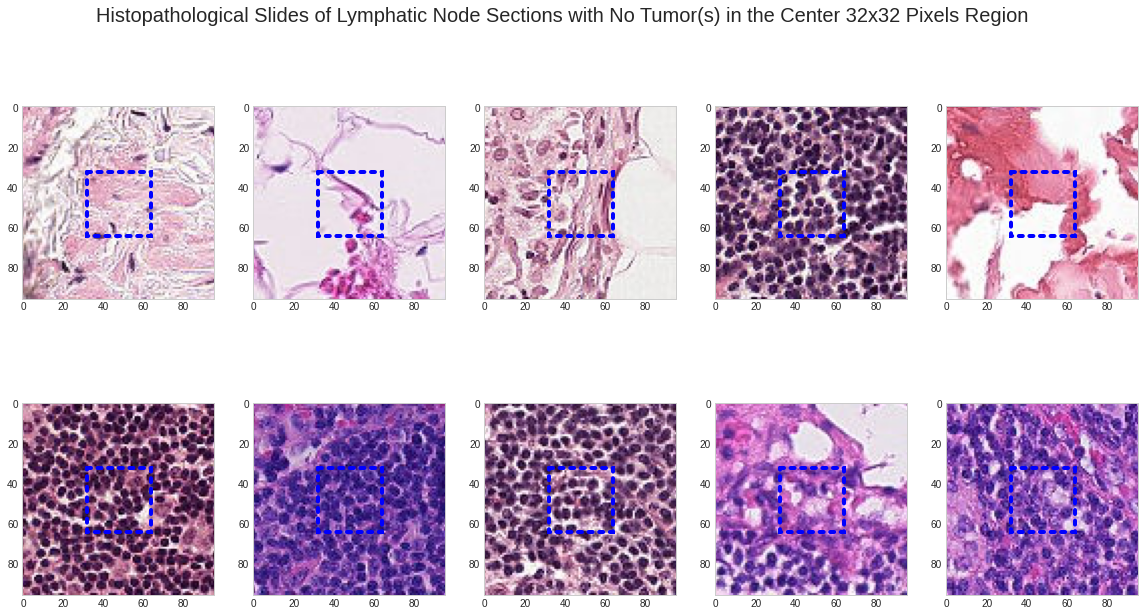

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=5,figsize=(20,10))

fig.suptitle('Histopathological Slides of Lymphatic Node Sections with No Tumor(s) in the Center 32x32 Pixels Region',fontsize=20)

for n in range(2):
    for m in range(5):
        name = non_tumor_slides['id'].sample().values[0]
        image_path = os.path.sep.join([TRAIN_IMAGES_PATH, name])
        ax[n, m].imshow(read_image(image_path + '.tif'))
        ax[n, m].grid(False)
        
        # Create a Rectangle patch
        box = patches.Rectangle(
            (32,32), 32, 32, linewidth=4, edgecolor='b', facecolor='none', linestyle=':', 
            capstyle='round'
        )
        ax[n, m].add_patch(box)

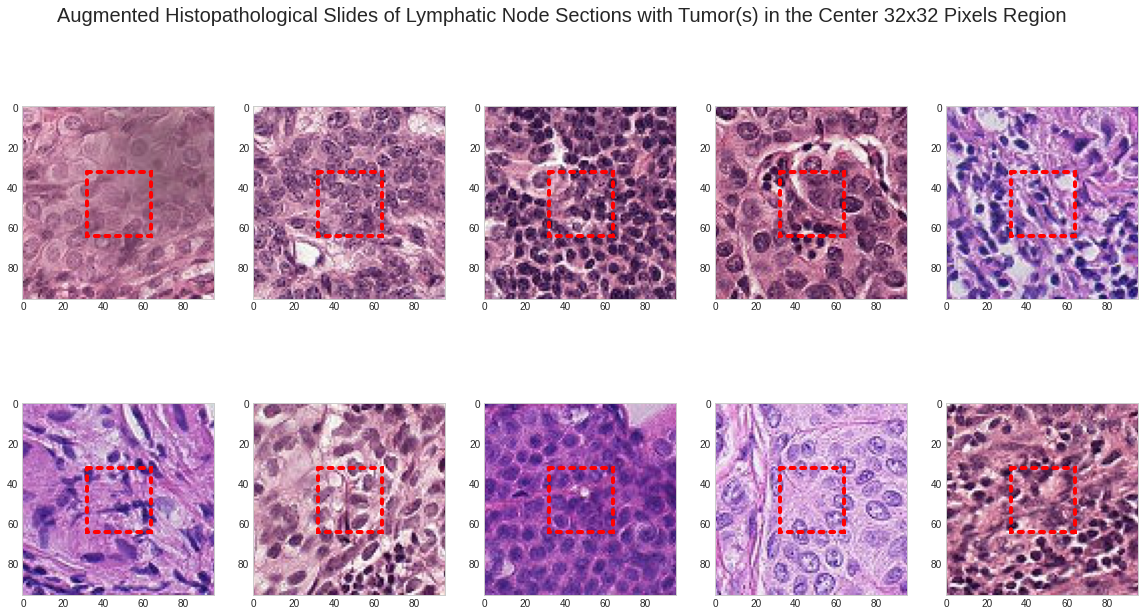

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5,figsize=(20,10))

fig.suptitle('Augmented Histopathological Slides of Lymphatic Node Sections with Tumor(s) in the Center 32x32 Pixels Region',fontsize=20)

for n in range(2):
    for m in range(5):
        name = tumor_slides['id'].sample().values[0]
        image_path = os.path.sep.join([TRAIN_IMAGES_PATH, name])
        ax[n, m].imshow(read_image(image_path + '.tif'))
        ax[n, m].grid(False)
        
        # Create a Rectangle patch
        box = patches.Rectangle(
            (32,32), 32, 32, linewidth=4, edgecolor='r', facecolor='none', linestyle=':', 
            capstyle='round'
        )
        ax[n, m].add_patch(box)

Classifying metastases is probably not an easy task for a trained pathologist and extremely difficult for an untrained eye. According to [Libre Pathology](https://librepathology.org/wiki/Lymph_node_metastasis), lymph node metastases can have these features:

> - Foreign cell population - key feature (Classic location: subcapsular sinuses)
- Cells with cytologic features of malignancy
    - Nuclear pleomorphism (variation in size, shape and staining).
    - Nuclear atypia:
        - **Nuclear enlargement**.
        - **Irregular nuclear membrane**.
        - **Irregular chromatin pattern, esp. asymmetry**.
        - **Large or irregular nucleolus**.
    - Abundant mitotic figures.
- Cells in architectural arrangements seen in malignancy; highly variable - dependent on tumour type and differentiation.
    - Gland formation.
    - Single cells.
    - Small clusters of cells.
  
**The takeaway from this is probably that irregular nuclear shapes, sizes or staining shades can indicate metastases.**

## 5. Data Augmentation <a class="anchor" id="Augmentation"></a>

In [9]:
def augmentations():
    return A.Compose([
        A.RandomRotate90(p=0.7),
        A.OneOf([
            A.HorizontalFlip(p=1), 
            A.VerticalFlip(p=1)]
        ),
        A.RandomBrightness(limit=0.07, p=0.5),
        A.RandomContrast(limit=0.07, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225),
                    max_pixel_value=255.0,
                    always_apply=False,
                    p=1.0
                   )
    ])

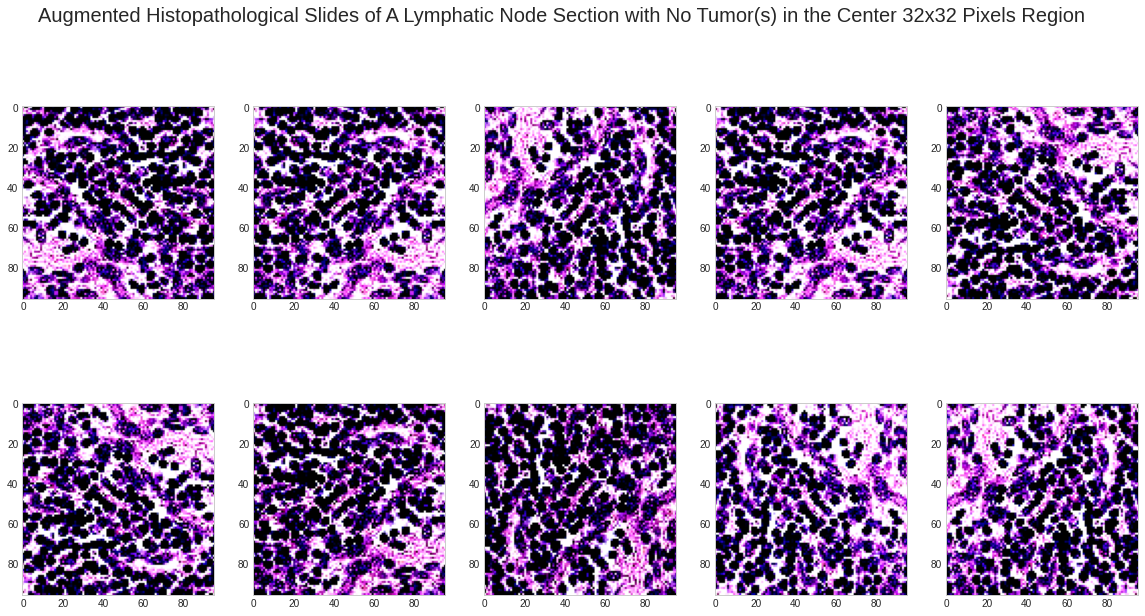

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=5,figsize=(20,10))

fig.suptitle('Augmented Histopathological Slides of A Lymphatic Node Section with No Tumor(s) in the Center 32x32 Pixels Region',fontsize=20)

for n in range(2):
    for m in range(5):
        name = non_tumor_slides['id'].iloc[500]
        image_path = os.path.sep.join([TRAIN_IMAGES_PATH, name])
        image_array = read_image(image_path + '.tif')
        augmented_image_array = augmentations()(image=image_array)['image']
        ax[n, m].imshow(augmented_image_array)
        ax[n, m].grid(False)

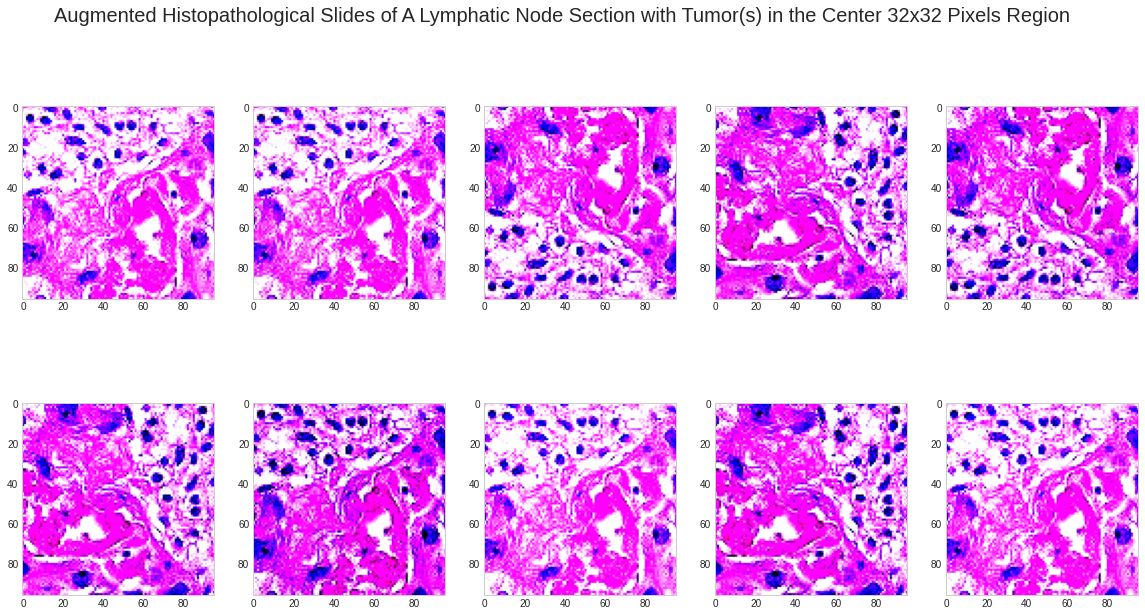

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=5,figsize=(20,10))

fig.suptitle('Augmented Histopathological Slides of A Lymphatic Node Section with Tumor(s) in the Center 32x32 Pixels Region',fontsize=20)

for n in range(2):
    for m in range(5):
        name = tumor_slides['id'].iloc[500]
        image_path = os.path.sep.join([TRAIN_IMAGES_PATH, name])
        image_array = read_image(image_path + '.tif')
        augmented_image_array = augmentations()(image=image_array)['image']
        ax[n, m].imshow(augmented_image_array)
        ax[n, m].grid(False)

## 6. Compute image statistics <a class="anchor" id="compute_stats"></a>

Compute the image statistics such that images with low low maximum pixel intensity (almost totally black) and/or very high minimum pixel intensity (almost totally white) are exempted from the calculation. This is due to the fact that these 'bad images' would affect the image statistics if included in the calculation.

The presence of these 'bad images' in the dataset is likely to be as a result of absence of tissue on the slide (plain glass?), cropping of a non stained part of the slide, cropping of an empty area of the actual image or poor exposure to light during capture.

In [12]:
# Compute the image statistics, and check if there are any too black or white images
black_threshold = 10 / 255
white_threshold = 245 / 255

names_of_too_white_images = []
names_of_too_black_images = []

stats_1 = np.zeros(3)
stats_2 = np.zeros(3)
counted = 0

for i, name in tqdm(enumerate(TRAIN_LABELS['id'])):
    image_path = os.path.sep.join([TRAIN_IMAGES_PATH, name])
    image_array = read_image(image_path + '.tif')/255
    image_array = image_array.reshape(-1, 3)
    # is this too dark?
    if(image_array.max() < black_threshold):
        names_of_too_black_images.append(name)
        continue 
    # is this too bright?
    if(image_array.min() > white_threshold):
        names_of_too_white_images.append(name)
        continue 
    stats_1 += image_array.mean(axis=0)
    stats_2 += (image_array**2).mean(axis=0)
    counted += 1
    
mean_of_channels = stats_1/counted
std_of_channels = np.sqrt(stats_2/counted - mean_of_channels**2)
print(mean_of_channels, std_of_channels)

220025it [13:50, 264.91it/s]

[0.70244707 0.54624322 0.69645334] [0.23889325 0.28209431 0.21625058]


In [13]:
print('There are {} extremely white images and {} extremely dark images'.format(
    len(names_of_too_white_images), len(names_of_too_black_images)
))
print('\n')
print('Extremely white images:')
print(names_of_too_white_images)
print('\n')
print('Extremely black images:')
print(names_of_too_black_images)

There are 6 extremely white images and 1 extremely dark images


Extremely white images:
['9071b424ec2e84deeb59b54d2450a6d0172cf701', 'f6f1d771d14f7129a6c3ac2c220d90992c30c10b', '5f30d325d895d873d3e72a82ffc0101c45cba4a8', '54df3640d17119486e5c5f98019d2a92736feabc', '5a268c0241b8510465cb002c4452d63fec71028a', 'c448cd6574108cf14514ad5bc27c0b2c97fc1a83']


Extremely black images:
['9369c7278ec8bcc6c880d99194de09fc2bd4efbe']


### Plot the extremely dark and white images

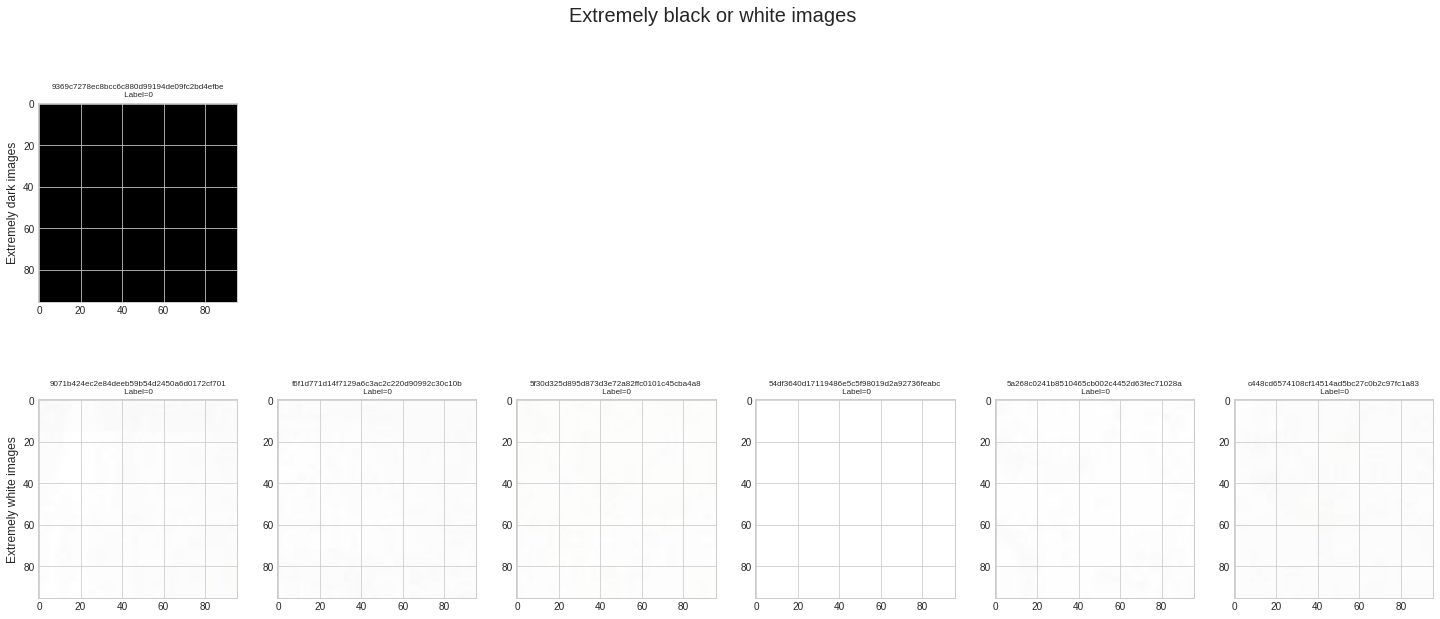

In [14]:
fig, ax = plt.subplots(2,6, figsize=(25,10))
fig.suptitle('Extremely black or white images',fontsize=20)
# Too dark
i = 0
for idx in np.asarray(names_of_too_black_images)[:min(6, len(names_of_too_black_images))]:
    label = TRAIN_LABELS[TRAIN_LABELS['id'] == idx]['label'].values[0]
    image_path = os.path.sep.join([TRAIN_IMAGES_PATH, idx])
    ax[0,i].imshow(read_image(image_path + '.tif'))
    ax[0,i].set_title(idx + '\n Label=' + str(label), fontsize = 8)
    i += 1
ax[0,0].set_ylabel('Extremely dark images', size='large')
for j in range(min(6, len(names_of_too_black_images)), 6):
    ax[0,j].axis('off') # hide axes if there are less than 6
# Too white
i = 0
for idx in np.asarray(names_of_too_white_images)[:min(6, len(names_of_too_white_images))]:
    label = TRAIN_LABELS[TRAIN_LABELS['id'] == idx]['label'].values[0]
    image_path = os.path.sep.join([TRAIN_IMAGES_PATH, idx])
    ax[1,i].imshow(read_image(image_path + '.tif'))
    ax[1,i].set_title(idx + '\n Label=' + str(label), fontsize = 8)
    i += 1
ax[1,0].set_ylabel('Extremely white images', size='large')
for j in range(min(6, len(names_of_too_white_images)), 6):
    ax[1,j].axis('off') # hide axes if there are less than 6